In [0]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize
from scipy.linalg import expm
import matplotlib.pyplot as plt
import time

# 4th Order Runge-Kutta (RK4) comparison to scipy.integrate
***


Basically, I am trying to modify the existing MPC algorithm to optimize to RK4 dynamics as opposed to linearized and discretized dynamics. This is probably easier and more accurate to do in matlab, but I need the practice. Remember to type cast your vectors, kids.

In [0]:
def ugvModel(x,t,u):
  #Model for UGV
  
  #x=<x,y,theta> [m,m,rad]
  #dx=<dx,dy,dtheta> [m/s,m/s,rad/s]
  #u=<v,gamma> [m/s,rad]
  #L=Length of Drivetrain [m]
  
  #Time-invariant so T unused
  L=0.2; #Length of wheel base in meters
  dx=np.array([0.,0.,0.]);
  dx[0]=u[0]*np.cos(x[2]);
  dx[1]=u[0]*np.sin(x[2]);
  dx[2]=u[0]/L*np.tan(u[1]);
  return dx

def ugvJac(x,u):
  #Hard-coded analytical Jacobian
  
  #x=<x,y,theta> [m,m,rad]
  #dx=<dx,dy,dtheta> [m/s,m/s,rad/s]
  #u=<v,gamma> [m/s,rad]
  #L=Length of Drivetrain [m]
  
  L=0.2
  A=np.array([[0.,0.,-u[0]*np.sin(x[2])],[0.,0.,u[0]*np.cos(x[2])],[0.,0.,0.]]) #SMat
  B=np.array([[np.cos(x[2]),0.],[np.sin(x[2]),0.],[1/L*np.tan(u[1]),u[0]/L/np.cos(u[1])**2]]) #IMat

  return (A,B)

def rk4(x,t_vec,u):
  #4th order Runge-Kutta implementation using recursive formulation
  #t_vec=time instances to be evaluated
  #u[:,t]=control inputs at the corresponding t
  
  #Validity Check
  assert(len(t_vec)==len(u[1,:]))
  
  #Constants
  h=t_vec[1]-t_vec[0]
  
  y=np.copy(x)
  
  #Order Four Formulas
  for t in range(len(t_vec)):
    f1=h*ugvModel(y[:,t],t*h,u[:,t])
    if 2*np.pi/f1[2]<=h*10: print "Angular Velocity (dx2) too high for good approximation" 
    f2=h*ugvModel(y[:,t]+f1/2,t*h+h/2,u[:,t])
    f3=h*ugvModel(y[:,t]+f2/2,t*h+h/2,u[:,t])
    f4=h*ugvModel(y[:,t]+f3,(t+1)*h,u[:,t])
    
    #lazy workaround of fencepost error on last iter
    try:
      y[:,t+1]=y[:,t]+((f1+f2+f2+f3+f3+f4)/6)
    except:
      pass
      #print "rk4 fencepost error" if: t==len(tvec)-1

  return y

def rk42(x,t_vec,u):
  #4th order Runge-Kutta implementation after collapsing recursive formulation
  #t_vec=time instances to be evaluated
  #u[:,t]=control inputs at the corresponding t
  #h=sample period
  
  #Validity Check
  assert(len(t_vec)==len(u[1,:]))
  
  y=np.copy(x)
  
  #Constant
  h=t_vec[1]-t_vec[0]
  
  #Collapsed RK4 equation
  for t in range(len(t_vec)):
    dy=ugvModel(y[:,t],t*h,u[:,t])
    
    #lazy workaround of fencepost error on last iter
    try:
      y[:,t+1]=y[:,t]+(h/6*np.array([[2*u[0,t]*np.cos(y[2,t]+h*dy[2]/2)*(2+np.cos(h*dy[2]/2))],\
                                     [2*u[0,t]*np.sin(y[2,t]+h*dy[2]/2)*(2+np.cos(h*dy[2]/2))],\
                                     [6*dy[2]]])).reshape(3,)
    except:
      pass
      #print "erk4 fencepost error" if: t==len(tvec)-1
    
  return y

def ldt(x,t_vec,u):
  #Method II discretization
  #Nilpotent of n=2, e^AT=I+AT
  
  #Ac=Continuous-Time State Matrix=Derivative of Model w.r.t. states
  #Bc=Continuous-Time Input Matrix=Derivative of Model w.r.t. inputs
  #Ad=Discrete-Time State Matrix
  #Bd=Discrete-Time Input Matrix
  #h=Sampling Period
  
  #Validity Check
  assert(len(t_vec)==len(u[1,:]))
  
  y=np.copy(x)
  
  h=t_vec[1]-t_vec[0]
  
  for t in range(len(t_vec)):
    Ac,Bc=ugvJac(y[:,t],u[:,t])
    Ad=np.eye(3)+h*Ac
    Bd=Bc*h+0.5*h**2*Ac.dot(Bc)
    
    #lazy workaround of fencepost error on last iter
    try:
      y[:,t+1]=(Ad.dot(y[:,t].reshape([3,1]))+Bd.dot(u[:,t].reshape([2,1]))).reshape(3)
    except:
      pass
      #print "ldt fencepost error" if: t==len(tvec)-1
    
  return y

In [0]:
#Run Predictions n times over for gettings performance stats
#Number of Trials
n=1000

#Matrix storing Trial Data
times=np.zeros([4,n],dtype="float64")

#Trial Loop
for k in range(n):
  #Initial Pose <x,y,theta>
  x0=np.array([5.,0.,np.pi/2]).reshape([3,1])
  
  #Initial Inputs <v,gamma>
  u0=np.array([3.,np.pi/12]).reshape([2,1])
  
  #10 second time horizon for 10 hz
  x=np.zeros([3,101],dtype='float64')
  x[:,0]=x0[:,0]
  
  #Constant Speed and Steer (Not Necessarily the Case)
  u=np.kron(u0,np.ones([1,101]))
  
  #Time instances to evaluate
  tspan=np.linspace(0,10,101)

  #Start the clocks
  init_time=time.time()

  #ODE
  x_ode=integrate.odeint(ugvModel,x0.reshape(3),tspan,args=(u0.reshape(2),))
  times[0,k]=time.time()-init_time
#   print "="*30

  #RK4
  x_rk=rk4(x,tspan,u)
  times[1,k]=time.time()-times[0,k]-init_time
#   print "="*30

  #Explicit RK4
  x_rk2=rk42(x,tspan,u)
  times[2,k]=time.time()-times[1,k]-times[0,k]-init_time
#   print "="*30

  #Linearized Discrete-Time
  x_ldt=ldt(x,tspan,u)
  times[3,k]=time.time()-times[2,k]-times[1,k]-times[0,k]-init_time

#Table of Results
print "="*30
print "RESULTS:"
print "-"*30
print "ODEint Time\tu: "+str(np.average(times[0,:]))+"\tstd: "+str(np.std(times[0,:]))
print "RK4 Time\tu: "+str(np.average(times[1,:]))+"\tstd: "+str(np.std(times[1,:]))
print "eRK4 Time\tu: "+str(np.average(times[2,:]))+"\tstd: "+str(np.std(times[2,:]))
print "LDT Time\tu: "+str(np.average(times[3,:]))+"\tstd: "+str(np.std(times[3,:]))

#Groundtruth
gtru=integrate.odeint(ugvModel,x0.reshape(3),np.linspace(0,10,1001),args=(u0.reshape(2),))

RESULTS:
------------------------------
ODEint Time	u: 4.086971282958984e-06	std: 0.00012917674300532466
RK4 Time	u: 6.736993789672852e-06	std: 0.00021293590170933722
eRK4 Time	u: 2.424955368041992e-06	std: 7.664547037143601e-05
LDT Time	u: 8.450984954833984e-06	std: 0.0002671099540640961


# Results
***
Basically the RK4 works great, but the LDT is REALLY bad. Also there is not a statistically significant runtime difference among RK4, eRK4 and odeint.

To-do:

-Vectorize RK4 algorithm if possible.

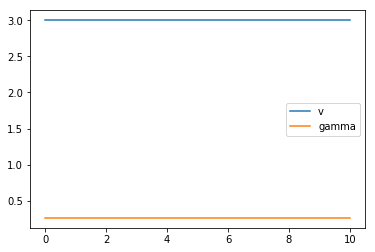

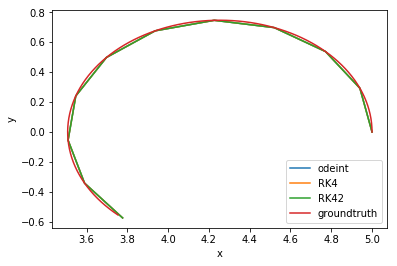

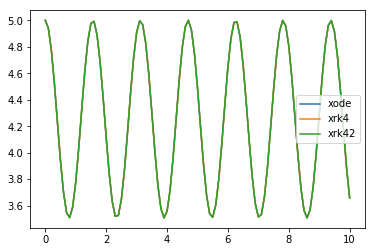

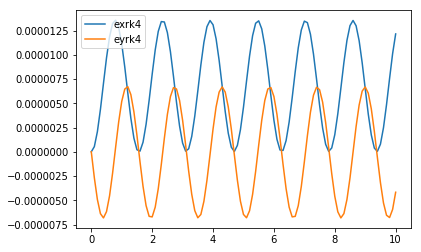

In [0]:
plt.plot(tspan,u[0],label="v")
plt.plot(tspan,u[1],label="gamma")
plt.legend()
plt.show()

plt.plot(x_ode[:11,0],x_ode[:11,1],label="odeint")
plt.plot(x_rk[0,:11],x_rk[1,:11],label="RK4")
plt.plot(x_rk2[0,:11],x_rk2[1,:11],label="RK42")
#plt.plot(x_ldt[0,:10],x_ldt[1,:10],label="ldt")
plt.plot(gtru[:100,0],gtru[:100,1],label="groundtruth")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

plt.plot(tspan,x_ode[:,0],label="xode")
# plt.plot(tspan,x_ode[:,1],label="yode")
plt.plot(tspan,x_rk[0,:],label="xrk4")
# plt.plot(tspan,x_rk[1,:],label="yrk4")
plt.plot(tspan,x_rk2[0,:],label="xrk42")
# plt.plot(tspan,x_rk2[1,:],label="yrk42")
# plt.plot(tspan,x_ldt[0,:],label="xldt")
# plt.plot(tspan,x_ldt[1,:],label="yldt")
plt.legend()
plt.show()

plt.plot(tspan,x_ode[:,0]-x_rk[0,:],label="exrk4")
plt.plot(tspan,x_ode[:,1]-x_rk[1,:],label="eyrk4")
# plt.plot(tspan,x_ode[:,0]-x_ldt[0,:],label="exldt")
# plt.plot(tspan,x_ode[:,1]-x_ldt[1,:],label="eyldt")
plt.legend()
plt.show()

# print x_rk.T-x_ode
# print "="*30
# print x_ode
# print x_ldt.T
# print "="*30
# print x_rk.T

# Cost Fcn Optimization Using Conjugate Gradient Descent
---
Basically I need to document this shit because it is taking way too long to pick up and put down this stuff.

J() is the basic formula I am optimizing, but it really doesn't have any functional use

H() evaluates the prediction horizon for RK4

rk4_jac() evaluates jacobian of prediction horizon for all the states using forward finite difference method (as opposed to bilateral).

Q=np.diag([q1,q2,q3])



In [0]:
def J(Q,R,y,du):
  J=y.T.dot(Q).dot(y)+du.T.dot(R).dot(du)
  
  return J

def H(xt,ut,y0,Np,h):
  eta_t=np.zeros([Np*3,1],dtype='float64')
  eta_t[0:3,:]=y0.reshape([3,1])
  for k in range(Np):
    dy0=h/6*2*ut[0,k]*np.cos(xt[2,k]+h*5/2*np.tan(ut[1,k]))*(2+np.cos(h*5/2*np.tan(ut[1,k])))-2*ut[2,k]*np.cos(xt[5,k]+h*5/2*np.tan(ut[3,k]))*(2+np.cos(h*5/2*np.tan(ut[3,k])))
    dy1=h/6*2*ut[0,k]*np.sin(xt[2,k]+h*5/2*np.tan(ut[1,k]))*(2+np.cos(h*5/2*np.tan(ut[1,k])))-2*ut[2,k]*np.sin(xt[5,k]+h*5/2*np.tan(ut[3,k]))*(2+np.cos(h*5/2*np.tan(ut[3,k])))
    dy2=h/6*30*(ut[0,k]*np.tan(ut[1,k])-ut[2,k]*np.tan(ut[3,k]))
    try:
      eta_t[(k+1)*3:(k+2)*3,0]=eta_t[k*3:(k+1)*3,0]+np.array([dy0,dy1,dy2])
    except:
      print "fencepost error?"
    #print "k++"
      
  return eta_t

def rk4_jac(eta,diff,xjac,ujac,Np):
  assert len(eta)%Np==0
  ups=np.zeros([len(eta),Np],dtype='float64')
  etas=np.zeros_like(ups)
  for k in range(Np):
    ujac[3,k]+=diff
    etas[:,k]=H(xjac,ujac,np.array([-1.4,0.,-np.pi]),10,.1).reshape(30,)
    ujac[3,k]-=diff
  ups=(etas-eta)/diff
  return ups
  

q0=440
q1=440
q2=0
qd=[q0,q1,q2]
Np=10
xnew=np.block([[x_rk],[x_rk]])
unew=np.block([[u],[u]])
print xnew.shape
print unew.shape
#print H(xnew,unew,np.array([-1.4,0.,-np.pi]),10,.1).reshape([3,10])
eta=H(xnew,unew,np.array([-1.4,0.,-np.pi]),10,.1)
jac=rk4_jac(eta,.001,xnew,unew,Np)
dV=np.zeros([3,10],dtype="float64")
for k in range(3):
  dV[k,:]=((jac[k::3,:].T).dot(np.ones([Np,1]))).reshape(10,)
grad_J=np.zeros([10,1])
for k in range(Np):
  for m in range(3):
    grad_J[k]+=qd[m]*np.sum(2*jac[m::3,k]*eta)

In [0]:
print jac[::3,0:6].reshape(10,6)
print "="*20
print jac[:,0:6]
print "="*20
print eta
print "="*20
print grad_J

In [0]:
print jac.shape
print eta.shape
print dV
print np.eye(2)*np.array([[2,2],[2,2]])
print times.T

#Cost Fcn Optimization using scipy.optimize.minimize
